In [1]:
import sys
sys.path.append('/mnt/d/ariel2/code/core/')
sys.path.append('d:/ariel2/code/core/')
sys.path.append('/kaggle/input/my-ariel2-library')
import kaggle_support as kgs
import ariel_model
import ariel_numerics
import ariel_gp
import ariel_load
import ariel_diagnostics
import time
import numpy as np
import multiprocess
import importlib
import copy
import cupy as cp
import matplotlib.pyplot as plt
from tqdm import tqdm

local


In [2]:
# import time
# time.sleep(3600)

In [3]:
train_data=kgs.load_all_train_data()
train_data=train_data

In [4]:
if False:
    R = 1125*len(train_data)
    C = 32*282

    A_row = np.memmap(kgs.temp_dir + 'AIRS_row.memmap',  dtype=np.float32, mode='w+', shape=(R, C), order='C')
    A_col = np.memmap(kgs.temp_dir + 'AIRS_col.memmap',  dtype=np.float32, mode='w+', shape=(R, C), order='F')
    
    B_row = np.memmap(kgs.temp_dir + 'AIRS_s_row.memmap',  dtype=np.float32, mode='w+', shape=(R, C), order='C')
    B_col = np.memmap(kgs.temp_dir + 'AIRS_s_col.memmap',  dtype=np.float32, mode='w+', shape=(R, C), order='F')
    
    scale_vals = []

    loaders = ariel_load.default_loaders()
    for ii in range(2):
        loaders[ii].apply_pixel_corrections.mask_hot= False
    loaders[1].apply_wavelength_binning.handle_mean = False
    loaders[1].apply_full_sensor_corrections.pca_options.n_components = 2
    loaders[1].apply_full_sensor_corrections.remove_background_based_on_rows = True
    loaders[1].apply_full_sensor_corrections.inpainting_2d = True
    loaders[1].apply_full_sensor_corrections.restore_invalids = True
    for ii,d in tqdm(enumerate(train_data)):
        d = copy.deepcopy(d)

        d.load_to_step(4, loaders)    
        data = copy.deepcopy(d.transits[0].data[1].data)
        
        #data = data-np.mean(data,0)    

        A_row[1125*ii:1125*(ii+1),:] = data.reshape(1125,32*282).get()
        A_col[1125*ii:1125*(ii+1),:] = data.reshape(1125,32*282).get()
        
        data_base = copy.deepcopy(d.transits[0].data[1].data)
        data = copy.deepcopy(d.transits[0].data[1].data)
        
        ariel_load.inpaint_vectorized(data)
        assert not cp.any(cp.isnan(data))
        x=cp.mean(data,(0,1))
        if d.planet_id == train_data[0].planet_id:
            base_scaling = x
            #kgs.dill_save(kgs.calibration_dir + 'AIRS_scaling6.pickle', base_scaling.get())
        data_base = data_base/x*base_scaling
        scale_vals.append(base_scaling/x)
        
        #data = data-np.mean(data,0)    

        B_row[1125*ii:1125*(ii+1),:] = data_base.reshape(1125,32*282).get()
        B_col[1125*ii:1125*(ii+1),:] = data_base.reshape(1125,32*282).get()


        if ii%20==0:
            A_row.flush()
            A_col.flush()
            B_row.flush()
            B_col.flush()

    A_row.flush()
    A_col.flush()
    B_row.flush()
    B_col.flush()
    kgs.clear_gpu()
    kgs.dill_save(kgs.temp_dir + 'scale_vals.pickle',scale_vals)
scale_vals = cp.array(kgs.dill_load(kgs.temp_dir + 'scale_vals.pickle'))

In [ ]:
if True:
    R_row = np.memmap(kgs.temp_dir + 'AIRS_s_row.memmap',  dtype=np.float32, mode='r', shape=(1125*len(train_data), 32*282), order='C')#[:5000,...]
    R_col = np.memmap(kgs.temp_dir + 'AIRS_s_col.memmap',  dtype=np.float32, mode='r', shape=(1125*len(train_data), 32*282), order='F')#[:5000,...]
    import mmap
    R_row._mmap.madvise(mmap.MADV_SEQUENTIAL)
    R_col._mmap.madvise(mmap.MADV_SEQUENTIAL)
    importlib.reload(ariel_numerics)
    kgs.profiling = False
    W_combined = np.zeros((R_row.shape[0],0))
    C_combined = np.zeros((0,R_row.shape[1]))
    for ii in range(3):
        W,C,S=ariel_numerics.nan_pca_rank1_memmap(R_row, R_col, W_combined, C_combined, row_batch = 4096, col_batch = 32, verbose=True, acc_dtype=np.float64, max_iter=15)
        W_combined = np.concatenate((W_combined, W[:,None]),1)
        C_combined = np.concatenate((C_combined, C),0)
        print(S)
        
        
    kgs.dill_save(kgs.calibration_dir + 'AIRS_jitter6.pickle', (C_combined, W_combined))

100%|█████████████████████████████████████████████████████████████████████████████████| 282/282 [05:57<00:00,  1.27s/it]


iter 01  ΔC_rel=1.000e+00


100%|█████████████████████████████████████████████████████████████████████████████████| 282/282 [06:19<00:00,  1.35s/it]


iter 02  ΔC_rel=1.119e-03


100%|█████████████████████████████████████████████████████████████████████████████████| 282/282 [08:10<00:00,  1.74s/it]


iter 03  ΔC_rel=1.064e-06


100%|█████████████████████████████████████████████████████████████████████████████████| 282/282 [08:11<00:00,  1.74s/it]


iter 04  ΔC_rel=1.037e-09
[6.537335e+08]


100%|█████████████████████████████████████████████████████████████████████████████████| 282/282 [07:02<00:00,  1.50s/it]


iter 01  ΔC_rel=9.997e-01


 48%|██████████████████████████████████████▊                                          | 135/282 [03:30<05:02,  2.06s/it]

In [ ]:
C_combined, W_combined = kgs.dill_load(kgs.calibration_dir + 'AIRS_jitter6.pickle')
for ii in range(3):
    #plt.figure(figsize=(20,20))
    plt.figure()
    plt.imshow(C_combined[ii,:].reshape(32,282), aspect='auto', interpolation='none')

In [17]:
signal_row = np.memmap(kgs.temp_dir + 'AIRS_row.memmap',  dtype=np.float32, mode='r', shape=(1125*len(train_data), 32*282), order='C')#[:5000,...]
n_t = signal_row.shape[0]
n_r = 32
n_wavelength = 282
n_comp = 3
if False:
    # general dimension order: [t, r, wavelength, comp]
    # signal: [t,r,wavelength]
    # W0: [t,wavelength]
    # W: [t,comp]
    # C: [r,wavelength,comp]

    
    signal_col = np.memmap(kgs.temp_dir + 'AIRS_col.memmap',  dtype=np.float32, mode='r', shape=(1125*len(train_data), 32*282), order='F')#[:5000,...]
    signal_row = signal_row.reshape(-1,32,282)#[:3*1125]
    signal_col = signal_row.reshape(-1,32,282)#[:3*1125]

    # Initialize
    W0 = cp.zeros((n_t, n_wavelength))*cp.nan
    for ii in range(scale_vals.shape[0]):
        W0[1125*ii:1125*(ii+1),:] = scale_vals[ii,:]
    W = cp.zeros((n_t, n_comp))
    #C = cp.zeros((n_r,n_wavelength,n_comp))
    C = cp.array(C_combined, dtype=cp.float64).reshape((n_comp, n_r, n_wavelength))
    C = cp.transpose(C,axes=(1,2,0))

    # Residual calculation
    #@kgs.profile_each_line
    def calc_residual(plot_some=False):
        all_sum = 0.
        if plot_some:
            _,ax = plt.subplots(1,3,figsize=(18,6))
        for jj in range(n_t//1125):
            t_slice = slice(1125*jj,1125*(jj+1))
            signal_guess = cp.zeros((1125,n_r,n_wavelength))
            for ii in range(n_comp):
                signal_guess += W0[t_slice,None,:]*W[t_slice,None,None,ii]*C[None,:,:,ii]      
            this_residual = cp.array(signal_row[t_slice],dtype=cp.float64)-signal_guess
            this_residual[cp.isnan(this_residual)]=0
            all_sum += kgs.rms(this_residual.astype(np.float64))
            if plot_some and jj<=2:
                plt.sca(ax[jj])
                plt.imshow(this_residual[0,...].get(), aspect='auto', interpolation='none')
                plt.colorbar()
                if jj==2:
                    plt.pause(0.001)
        return all_sum/(n_t//1125)


    #kgs.profiling=True
    #print(calc_residual(plot_some=True))

    n_iter = 3
    n_w_iter = 2
    for i_iter in range(n_iter):
        print(i_iter)
        n_batch = 1125
        for jj in tqdm(range(n_t//n_batch)):
            # Get data for W0 and W updates     
            t_slice = slice(n_batch*jj,n_batch*(jj+1))
            this_signal = cp.array(signal_row[t_slice,...],dtype=cp.float64)
            rhs = this_signal.reshape(n_batch,n_r*n_wavelength,1)
            isnan = cp.isnan(rhs[0,:,0])           
            rhs[:,isnan,:] = 0
            for i_w_iter in range(n_w_iter):
                # W update           
                design_matrix = W0[t_slice,None,:,None]*C[None,:,:,:]
                design_matrix = design_matrix.reshape(n_batch, n_r*n_wavelength,n_comp)            
                design_matrix[:,isnan,:]=0
                AtA = cp.einsum('tmn,tmk->tnk', design_matrix, design_matrix)    # (n_t, n_comp, n_comp)
                Atb = cp.einsum('tmn,tmk->tnk', design_matrix, rhs)   # (t, n, 1)
                coeffs = cp.linalg.solve(AtA,Atb)
                assert not cp.any(cp.isnan(coeffs))
                W[t_slice,:] = coeffs[:,:,0]

                # W0 update
                sum_wi_ci = cp.zeros((n_batch, n_r, n_wavelength))
                for i_comp in range(n_comp):
                    sum_wi_ci += W[t_slice,None,None,i_comp] * C[None,:,:,i_comp]
                sum_wi_ci = sum_wi_ci.reshape(n_batch, n_r*n_wavelength)
                sum_wi_ci[:,isnan] = 0 
                sum_wi_ci = sum_wi_ci.reshape(n_batch, n_r, n_wavelength)
                rhs2 = rhs.reshape(n_batch, n_r, n_wavelength)
                W0[t_slice, :] = cp.sum(rhs2*sum_wi_ci,1) / cp.sum(sum_wi_ci*sum_wi_ci,1)
               # print(cp.sum(rhs*sum_wi_ci,1).shape)
        print('after W and W0', calc_residual(plot_some=True))

        # C update
        for i_r in tqdm(range(n_r)):
            for i_wl in range(n_wavelength):
                this_signal = cp.array(signal_col[:,i_r,i_wl], dtype=cp.float64)
                notnan = ~cp.isnan(this_signal)
                this_signal = this_signal[notnan]
                design_matrix = W0[notnan,i_wl,None] * W[notnan]    # (n_t, n_comp)
                coeffs = cp.linalg.lstsq(design_matrix, this_signal, rcond=None)
                assert not cp.any(cp.isnan(coeffs[0]))
                C[i_r,i_wl,:] = coeffs[0]
                #print(design_matrix.shape)
                #np.mean(this_signal)

        print('after C', calc_residual(plot_some=True))
    
    kgs.dill_save(kgs.temp_dir + 'AIRS_W6.pickle', (W,W0))
    kgs.dill_save(kgs.calibration_dir + 'AIRS_C6.pickle', C)


    #print(calc_residual(plot_some=True))
W,W0 = kgs.dill_load(kgs.temp_dir + 'AIRS_W6.pickle')
C = kgs.dill_load(kgs.calibration_dir + 'AIRS_C6.pickle')

In [18]:
# import subprocess

# # Hibernate Windows
# subprocess.run(
#     ["/mnt/c/Windows/System32/shutdown.exe", "/h"],  # add "/f" to force-close apps
#     check=True
# )

In [19]:
if False:
    kgs.debugging_mode = 1
    kgs.profiling=False
    kgs.sanity_checks_active = False
    model = ariel_gp.PredictionModel()
    model.run_in_parallel = False
    model.model_options.n_iter=0
    model.model_options.use_training_labels = True
    model.train(train_data)
    loaded_res = kgs.dill_load(kgs.temp_dir + '/prep3.pickle')
    model.infer(train_data[0:1]);
    transits = []
    for d,r in tqdm(zip(train_data,loaded_res)):
        mm= copy.deepcopy(model.results['model_mean'])
        #mm.m['signal'].m['main'].m['transit'].transit_params[0][0] = d.transit_params
        #mm.m['signal'].m['main'].m['transit'].transit_params[0][0].u = [0,0]
        #mm.m['signal'].m['main'].m['transit'].transit_params[0][1] = d.transit_params
        #mm.m['signal'].m['main'].m['transit'].transit_params[0][1].u = [0,0]
        mm.m['signal'].m['main'].m['transit'].transit_params = r[1]
        mm.set_parameters(r[0])
        mm.m['signal'].m['main'].m['transit'].depth_model.offset = -d.diagnostics['training_spectrum']    
        obs_transit = copy.deepcopy(model.results['obs'])

        stellar_labels = mm.m['signal'].m['main'].m['spectrum'].get_prediction(obs_transit)
        transit_labels = mm.m['signal'].m['main'].m['transit'].get_prediction(obs_transit)
        obs_transit.labels = stellar_labels*transit_labels
        #obs_transit.labels = model.results['model_mean'].m['signal'].m['main'].m['transit'].get_prediction(obs_transit)
        #obs_transit.labels = mm.m['signal'].m['main'].get_prediction(obs_transit)
        #obs_transit.labels = mm.m['signal'].get_prediction(obs_transit)
        #print(mm.m['signal'].m['main'].m['transit'].get_parameters())
        #d.diagnostics['transit'] = obs_transit
        transits.append(obs_transit.export_matrix(True))
    #del loaded_res
    #del mm
    #del model
    transits = cp.array(np.concatenate(transits))
    kgs.dill_save(kgs.temp_dir + 'AIRS_transits.pickle', transits)
    
transits = kgs.dill_load(kgs.temp_dir + 'AIRS_transits.pickle')
transits.shape

(112500, 282)

In [20]:
N=len(train_data)
ws=100
deg=4
all_coeffs_lf = W[:,None,:]*W0[:,:,None]
for ii in range(N):
    all_coeffs_lf[1125*ii:1125*(ii+1),:] -= ariel_numerics.remove_trend_cp(all_coeffs_lf[1125*ii:1125*(ii+1),:], window_size=ws, degree=deg)
del W
del W0
target_lf = cp.array(transits)
for ii in range(N):
    target_lf[1125*ii:1125*(ii+1)] -= ariel_numerics.remove_trend_cp(target_lf[1125*ii:1125*(ii+1)], window_size=ws, degree=deg)

In [21]:
order = 4
design_matrix_base = np.zeros((1125, n_wavelength, order**2))
#design_matrix_base = np.zeros((1125*len(train_data), 4*len(train_data)))
x = np.arange(1125)
x_norm = 2*(x - x.min())/(x.max() - x.min()) - 1
y = np.arange(n_wavelength)
y_norm = 2*(y - y.min())/(y.max() - y.min()) - 1
for i_order1 in range(order):
    for i_order2 in range(order):
        coeffs1 = np.zeros(order)
        coeffs1[i_order1]=1
        coeffs2 = np.zeros(order)
        coeffs2[i_order2]=2
        design_matrix_base[:,:,order*i_order1+i_order2] = np.polynomial.chebyshev.chebval(x_norm, coeffs1)[:,None] * np.polynomial.chebyshev.chebval(y_norm, coeffs2)[None,:]
design_matrix_base = cp.array(design_matrix_base[:,:,1:])

In [41]:
def f(p, show=False):
    p = copy.deepcopy(p)
    p[0] = 1
    cost = 0
   # global ratio_list
   # ratio_list = []
    for ii in range(N):
       # if not do_which[ii]:
       #     ratio_list.append(cp.array(0))
       #     continue
        #pred = cp.sum(cp.array(p)*all_coeffs[1125*ii:1125*(ii+1),:,:],2)
        #pred_lf = pred - ariel_numerics.remove_trend_cp(pred, window_size=ws, degree=deg)
        #pred_lf = cp.array(p[n_comp:])*cp.sum(cp.array(p[:n_comp])*all_coeffs_lf[1125*ii:1125*(ii+1),:,:],2)
        pred_lf = cp.array(cp.sum(cp.array(p[:n_comp])*all_coeffs_lf[1125*ii:1125*(ii+1),:,:],2))
        pred_lf = pred_lf/cp.mean(pred_lf,0)
        if ii==38 and show:
            plt.figure();plt.imshow(pred_lf.get(), aspect='auto', interpolation='none');plt.colorbar()
        pred_lf = pred_lf.reshape(1125*n_wavelength)
        
        #this_target =target[1125*ii:1125*(ii+1)]
        this_target_lf = target_lf[1125*ii:1125*(ii+1)]
        #print(ii, cp.sum(cp.isnan(this_target_lf)))
        #print(cp.std(this_target_lf,0).shape)
        if ii==38 and show:
            #print(ii, cp.sum(cp.isnan(this_target_lf)), cp.max(this_target_lf), cp.min(this_target_lf))
            plt.figure();plt.imshow(this_target_lf.get(), aspect='auto', interpolation='none');plt.colorbar()
            plt.title(this_target_lf.shape)
            #plt.figure();plt.plot(cp.mean(this_target_lf,0).get())
            #plt.figure();plt.plot(cp.mean(this_target_lf,1).get())
        this_target_lf = this_target_lf/cp.mean(this_target_lf,0)
        #print(this_target_lf.shape)
        if ii==38 and show:
            #print(ii, cp.sum(cp.isnan(this_target_lf)), cp.max(this_target_lf), cp.min(this_target_lf))
            plt.figure();plt.imshow(this_target_lf.get(), aspect='auto', interpolation='none');plt.colorbar()
            plt.title(this_target_lf.shape)
        #this_target_lf = this_target - ariel_numerics.remove_trend_cp(this_target, window_size=ws, degree=deg)
        #print(pred_lf.shape, this_target_lf.shape)
        design_matrix = design_matrix_base*this_target_lf[:,:,None]
        design_matrix = design_matrix.reshape(1125*n_wavelength, -1)
        #print(design_matrix.shape)
        #print((design_matrix.T@design_matrix).shape)
        #print((design_matrix.T@pred_lf).shape)
        #print(pred_lf.shape, this_target_lf.shape)
        this_target_lf = this_target_lf.reshape(1125*282)
        coeffs = cp.linalg.solve(design_matrix.T@design_matrix, design_matrix.T@(pred_lf-this_target_lf))
        this_target_lf = design_matrix@coeffs+this_target_lf
        residual_lf = pred_lf - this_target_lf
        if ii==38 and show:
            plt.figure();plt.imshow(residual_lf.reshape(1125,282).get(), aspect='auto', interpolation='none');plt.colorbar()
            plt.figure();plt.plot(ariel_numerics.estimate_noise_cp(pred_lf.reshape(1125,282)).get())
            #plt.figure();plt.imshow((pred_lf-this_target_lf).reshape(1125,282).get(), aspect='auto', interpolation='none');plt.colorbar()
        #this_target = (design_matrix_fit_cp*this_target[:,:,None])@coeffs        
        
           # plt.figure();plt.imshow(cp.sum(cp.array(p)*all_coeffs_lf[1125*ii:1125*(ii+1),:,:],2).get(), aspect='auto', interpolation='none');plt.colorbar()
#         if diags:# and ii==2:
#             #pred = pred - ariel_numerics.remove_trend_cp(pred)
#             #this_target = this_target - ariel_numerics.remove_trend_cp(this_target)
#             plt.figure()
#             plt.plot(pred_lf.get())#-this_target_lf.get())
#             plt.plot(this_target_lf.get())
#             plt.title(ii)
            
# #             plt.figure()
# #             plt.plot(pred.get())
# #             plt.plot(this_target.get())
# #             plt.title(ii)
            
#             plt.figure()
#             plt.plot(w[1125*ii:1125*(ii+1),3])
#             plt.plot(w[1125*ii:1125*(ii+1),5])
            
        this_cost = kgs.rms(residual_lf)
        #print(ii,this_cost)
       # print(this_cost)
        
        
       # ratio_list.append(this_cost/kgs.rms(pred-this_target))
        cost += this_cost.get()/N
    
   # ratio_list = cp.array(ratio_list).get()
    print(cost)
    return cost

0.0011109760024580985


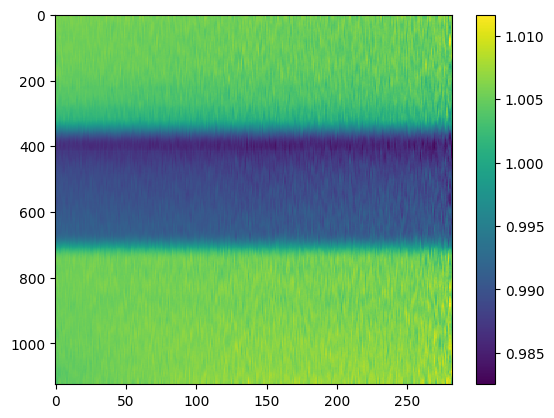

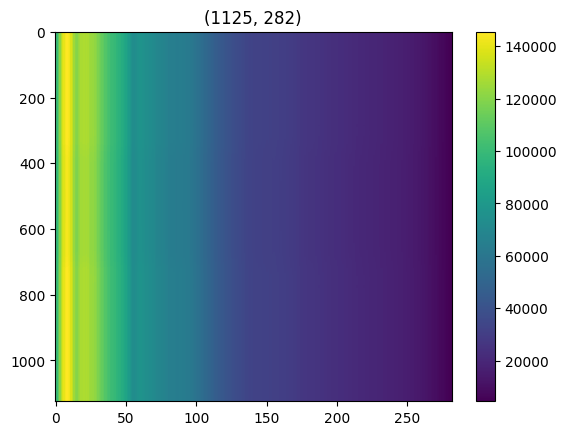

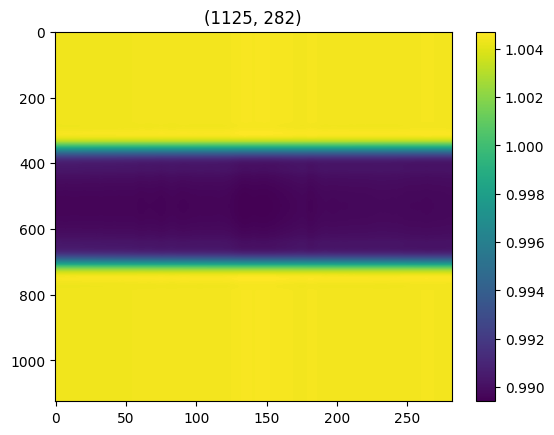

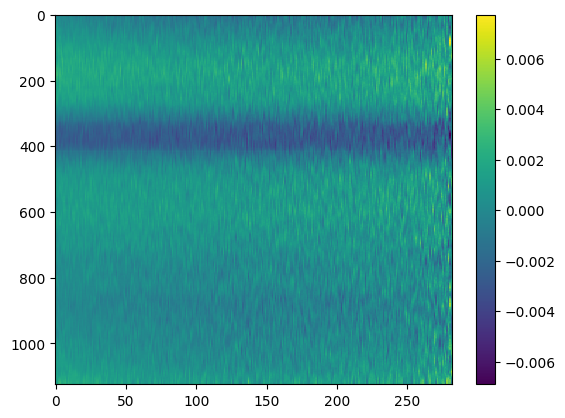

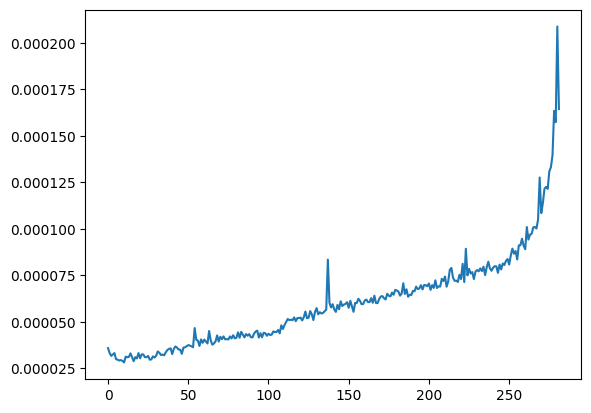

0.0011109760024580985
0.0011109760024580985
0.0011109759849014435
0.0011109760050444966
0.0011095581362805982
0.0011095581362805982
0.0011095581187346674
0.0011095581388654706
0.0011038953807612118
0.0011038953807612118
0.0011038953632586097
0.0011038953833399175
0.0010813877270076213
0.0010813877270076213
0.0010813877096855292
0.001081387729560619
0.00099393868108235
0.00099393868108235
0.0009939386646156615
0.000993938683513112
0.000715313501452099
0.000715313501452099
0.0007153134923893887
0.0007153135028128653
0.0007709591374380673
0.0007709591374380673
0.0007709591492739199
0.0007709591357425538
0.0006575762838455508
0.0006575762838455508
0.0006575762835744416
0.0006575762839250216
0.0006575315555369332
0.0006575315555369332
0.0006575315555773902
0.0006575315555708549
0.0006575315555369332


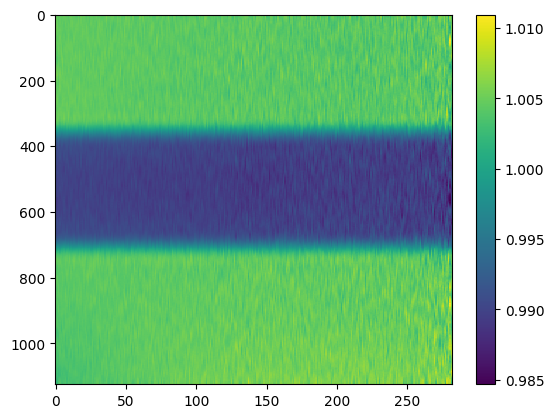

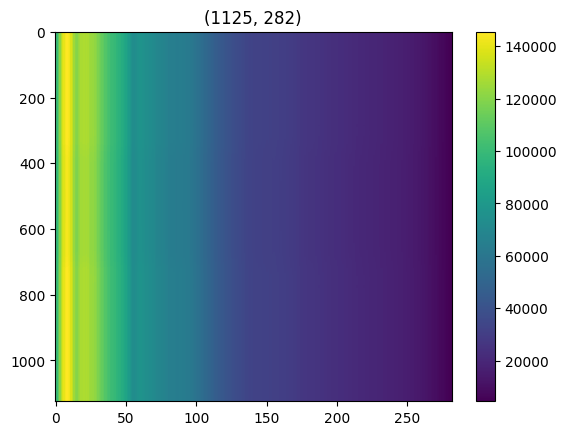

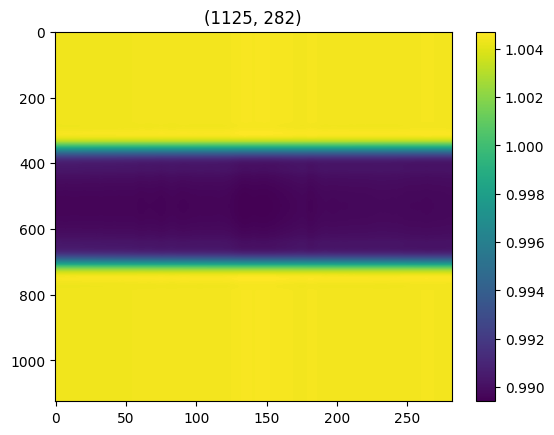

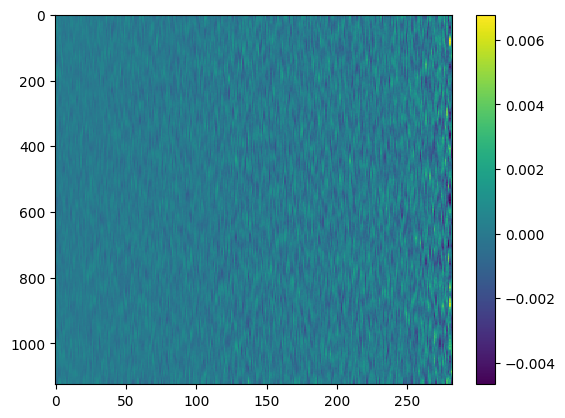

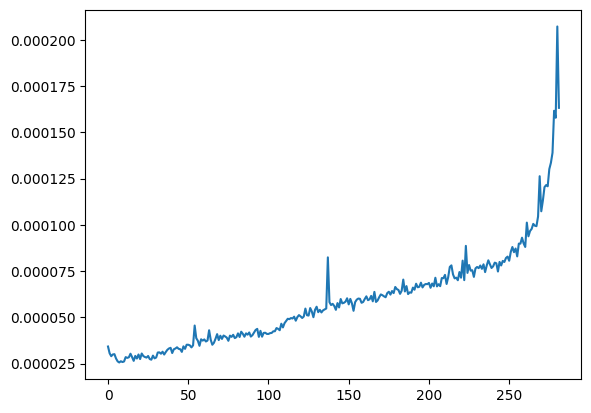

In [42]:
import scipy
p0 = np.zeros(n_comp)
p0[1]=p0[2]=0
p0[0] = 1
#p0[3:] = cp.sum(C[:,:,0],0).get()
f(p0,show=True)
plt.pause(0.001)
res=scipy.optimize.minimize(f,p0)
res.x[0]=1
f(res.x,show=True)
kgs.dill_save(kgs.calibration_dir + 'AIRS_weights6.pickle', res.x)

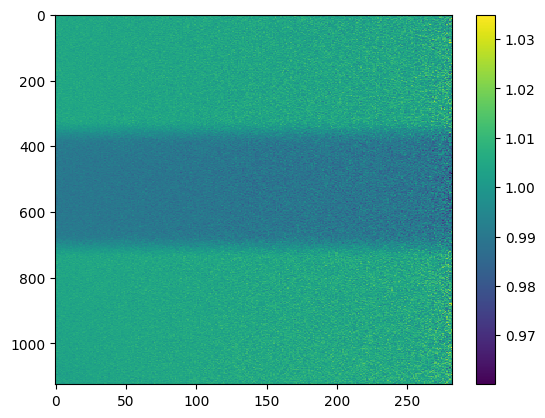

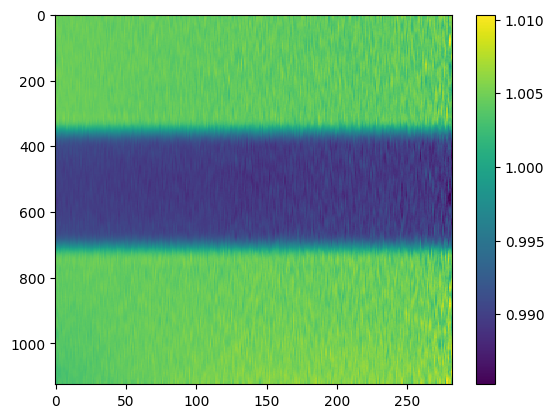

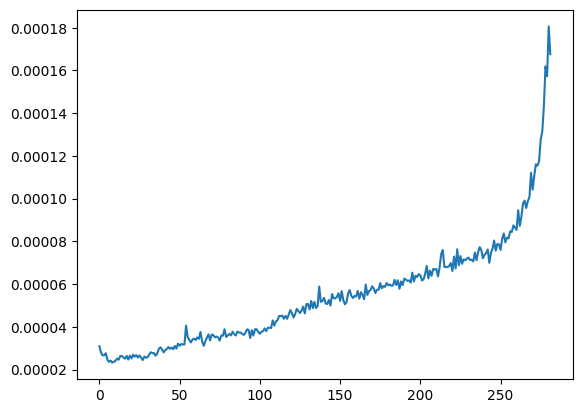

In [44]:
d=copy.deepcopy(train_data[38])
d.load_to_step(5, ariel_load.default_loaders())
data = d.transits[0].data[1].data
#data = data/cp.mean(data,0)
plt.figure();plt.imshow((data/cp.mean(data,0)).get(), aspect='auto', interpolation='none')
plt.colorbar()

data -= ariel_numerics.remove_trend_cp(data, window_size=ws, degree=deg)

plt.figure();plt.imshow((data/cp.mean(data,0)).get(), aspect='auto', interpolation='none')
plt.colorbar()

plt.figure();plt.plot(ariel_numerics.estimate_noise_cp(data/cp.mean(data,0)).get())

In [ ]:
target_lf.shape

In [ ]:
len(train_data)

In [78]:
import ariel_load_AIRS
importlib.reload(ariel_load_AIRS)
ariel_load_AIRS.AIRS_C6[1].shape
loaders = ariel_load.default_loaders()
loaders[0].cache_steps=[4]
loaders[1].apply_wavelength_binning = ariel_load_AIRS.ApplyWavelengthBinningAIRS3()
d = copy.deepcopy(train_data[38])
d.load_to_step(5, loaders)

In [77]:
32*282

9024